# EDA On Wifire BP3D Runs Dataset
Key Questions: 
- What existing features are useful in predicting the run time of a wifire simulation? 
- What features can be created to assist in eventually training a prediction model?
- What is the correlation between different variables and runtime?

# Setup

In [53]:
from tqdm import tqdm
import pandas as pd
from pprint import pprint
from rich import print as show
from datetime import datetime, timedelta
import time
import seaborn as sns
import ast
from sklearn.preprocessing import MinMaxScaler

In [54]:
simulation_runs = pd.read_csv("simulation_runs.csv")
print(simulation_runs.columns)

Index(['Unnamed: 0', 'path', 'time_scraped', 'canopy_moisture', 'dz', 'extent',
       'extent_fmt', 'fire_grid', 'fuel', 'ignition', 'output', 'resolution',
       'resolution_units', 'run_binary', 'run_end', 'run_max_mem_rss_bytes',
       'run_start', 'seed', 'sim_time', 'surface_moisture', 'threads',
       'timestep', 'topo', 'wind_direction', 'wind_speed'],
      dtype='object')


In [55]:

def calculate_area(str):
    #where p1 in the bottom left = (x1,y1) and p2 in the bottom left = (x2,y2)
    L = ast.literal_eval(str)
    x1, y1, x2, y2 = float(L[0]), float(L[1]), float(L[2]), float(L[3])
    
    area = (x2-x1) * (y2-y1)
    return abs(area)


def get_run_time(run_start,run_end):
    start = datetime.fromisoformat(run_start)
    end = datetime.fromisoformat(run_end)
    return (end-start).seconds


# DataFrame Reshaping
add area column generated from `extent` and only extract relevant columns. Add all attrs from `output` as individual columns too

In [56]:
# look into topo
useful_columns = [
    "sim_time",
    "run_start",
    "run_end",
    "output",
    "extent",
    "surface_moisture",
    "timestep",
    "wind_direction",
    "wind_speed",
    "canopy_moisture",
    "resolution",
    "run_max_mem_rss_bytes",
    "seed"
]
run_data = simulation_runs.get(useful_columns)
column = run_data.apply(lambda row: calculate_area(row["extent"]), axis=1)
run_data = run_data.drop(columns=["extent"])
run_data = run_data.dropna(subset="output")

In [57]:

# add new columns

runtime = run_data.apply(
    lambda row: get_run_time(row["run_start"],row["run_end"]),
    axis=1
)

steps_fire = run_data.apply(
    lambda row: ast.literal_eval(row["output"])["steps_fire"],
    axis=1
)

# steps_wind = run_data.apply(
#     lambda row: ast.literal_eval(row["output"])["steps_wind"],
#     axis=1
# ) 
# everything was 100

run_data.insert(0,'runtime', runtime)
run_data = run_data.assign(area=column, steps_fire=steps_fire)
run_data = run_data.drop(columns=["run_start","run_end","output"])

run_data.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,resolution,run_max_mem_rss_bytes,seed,area,steps_fire
0,5475,4503,0.10,600,65.0,2.235,1.00,"[2.0, 2.0, 1.0]",1934680,-1,560976.0,600
1,9737,11382,0.05,600,90.0,4.470,0.90,"[2.0, 2.0, 1.0]",2470180,-1,1981888.0,600
2,501,3937,0.12,600,270.0,2.235,0.95,"[2.0, 2.0, 1.0]",517424,-1,359488.0,600
3,4325,4921,0.10,600,137.0,3.000,1.10,"[2.0, 2.0, 1.0]",2454040,-1,1053216.0,600
4,9008,14997,0.15,600,360.0,4.470,1.00,"[2.0, 2.0, 1.0]",3919432,-1,648024.0,600


In [58]:
print(run_data.shape)
duplicate_rows_df = run_data[run_data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)
run_data = run_data.drop_duplicates()

run_data.count()

(1801, 12)
number of duplicate rows:  (234, 12)


runtime                  1567
sim_time                 1567
surface_moisture         1567
timestep                 1567
wind_direction           1567
wind_speed               1567
canopy_moisture          1567
resolution               1567
run_max_mem_rss_bytes    1567
seed                     1567
area                     1567
steps_fire               1567
dtype: int64

<Axes: >

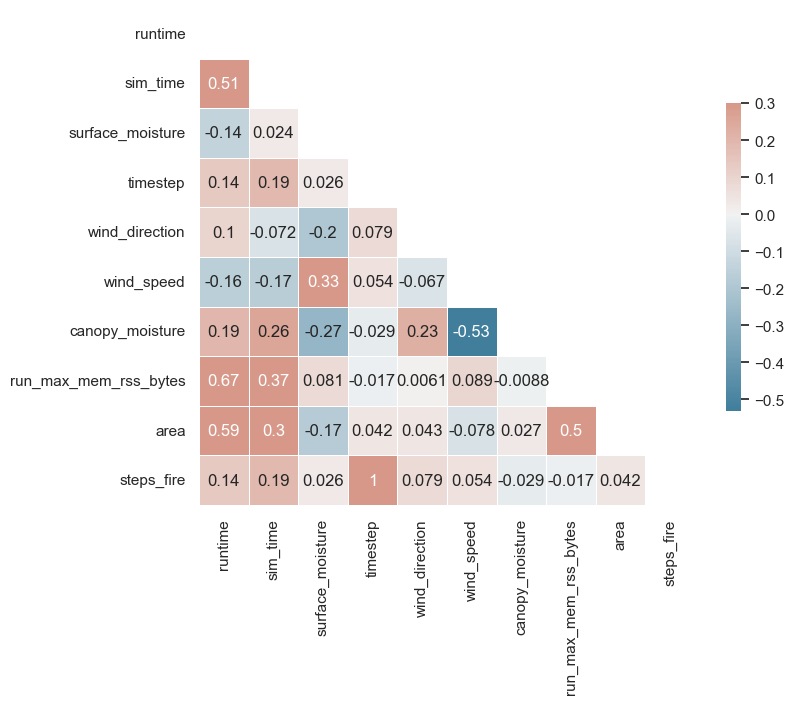

In [59]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

run_data = run_data.drop(columns=["resolution","seed"])

# Compute the correlation matrix
corr = run_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            annot=True,square=True, linewidths=.5, cbar_kws={"shrink": .5})

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/cq/f_dhjpgn6f1gjlvmswx1nx4h0000gs/T/ipykernel_90875/1120009799.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


[]

<Figure size 1500x1000 with 0 Axes>

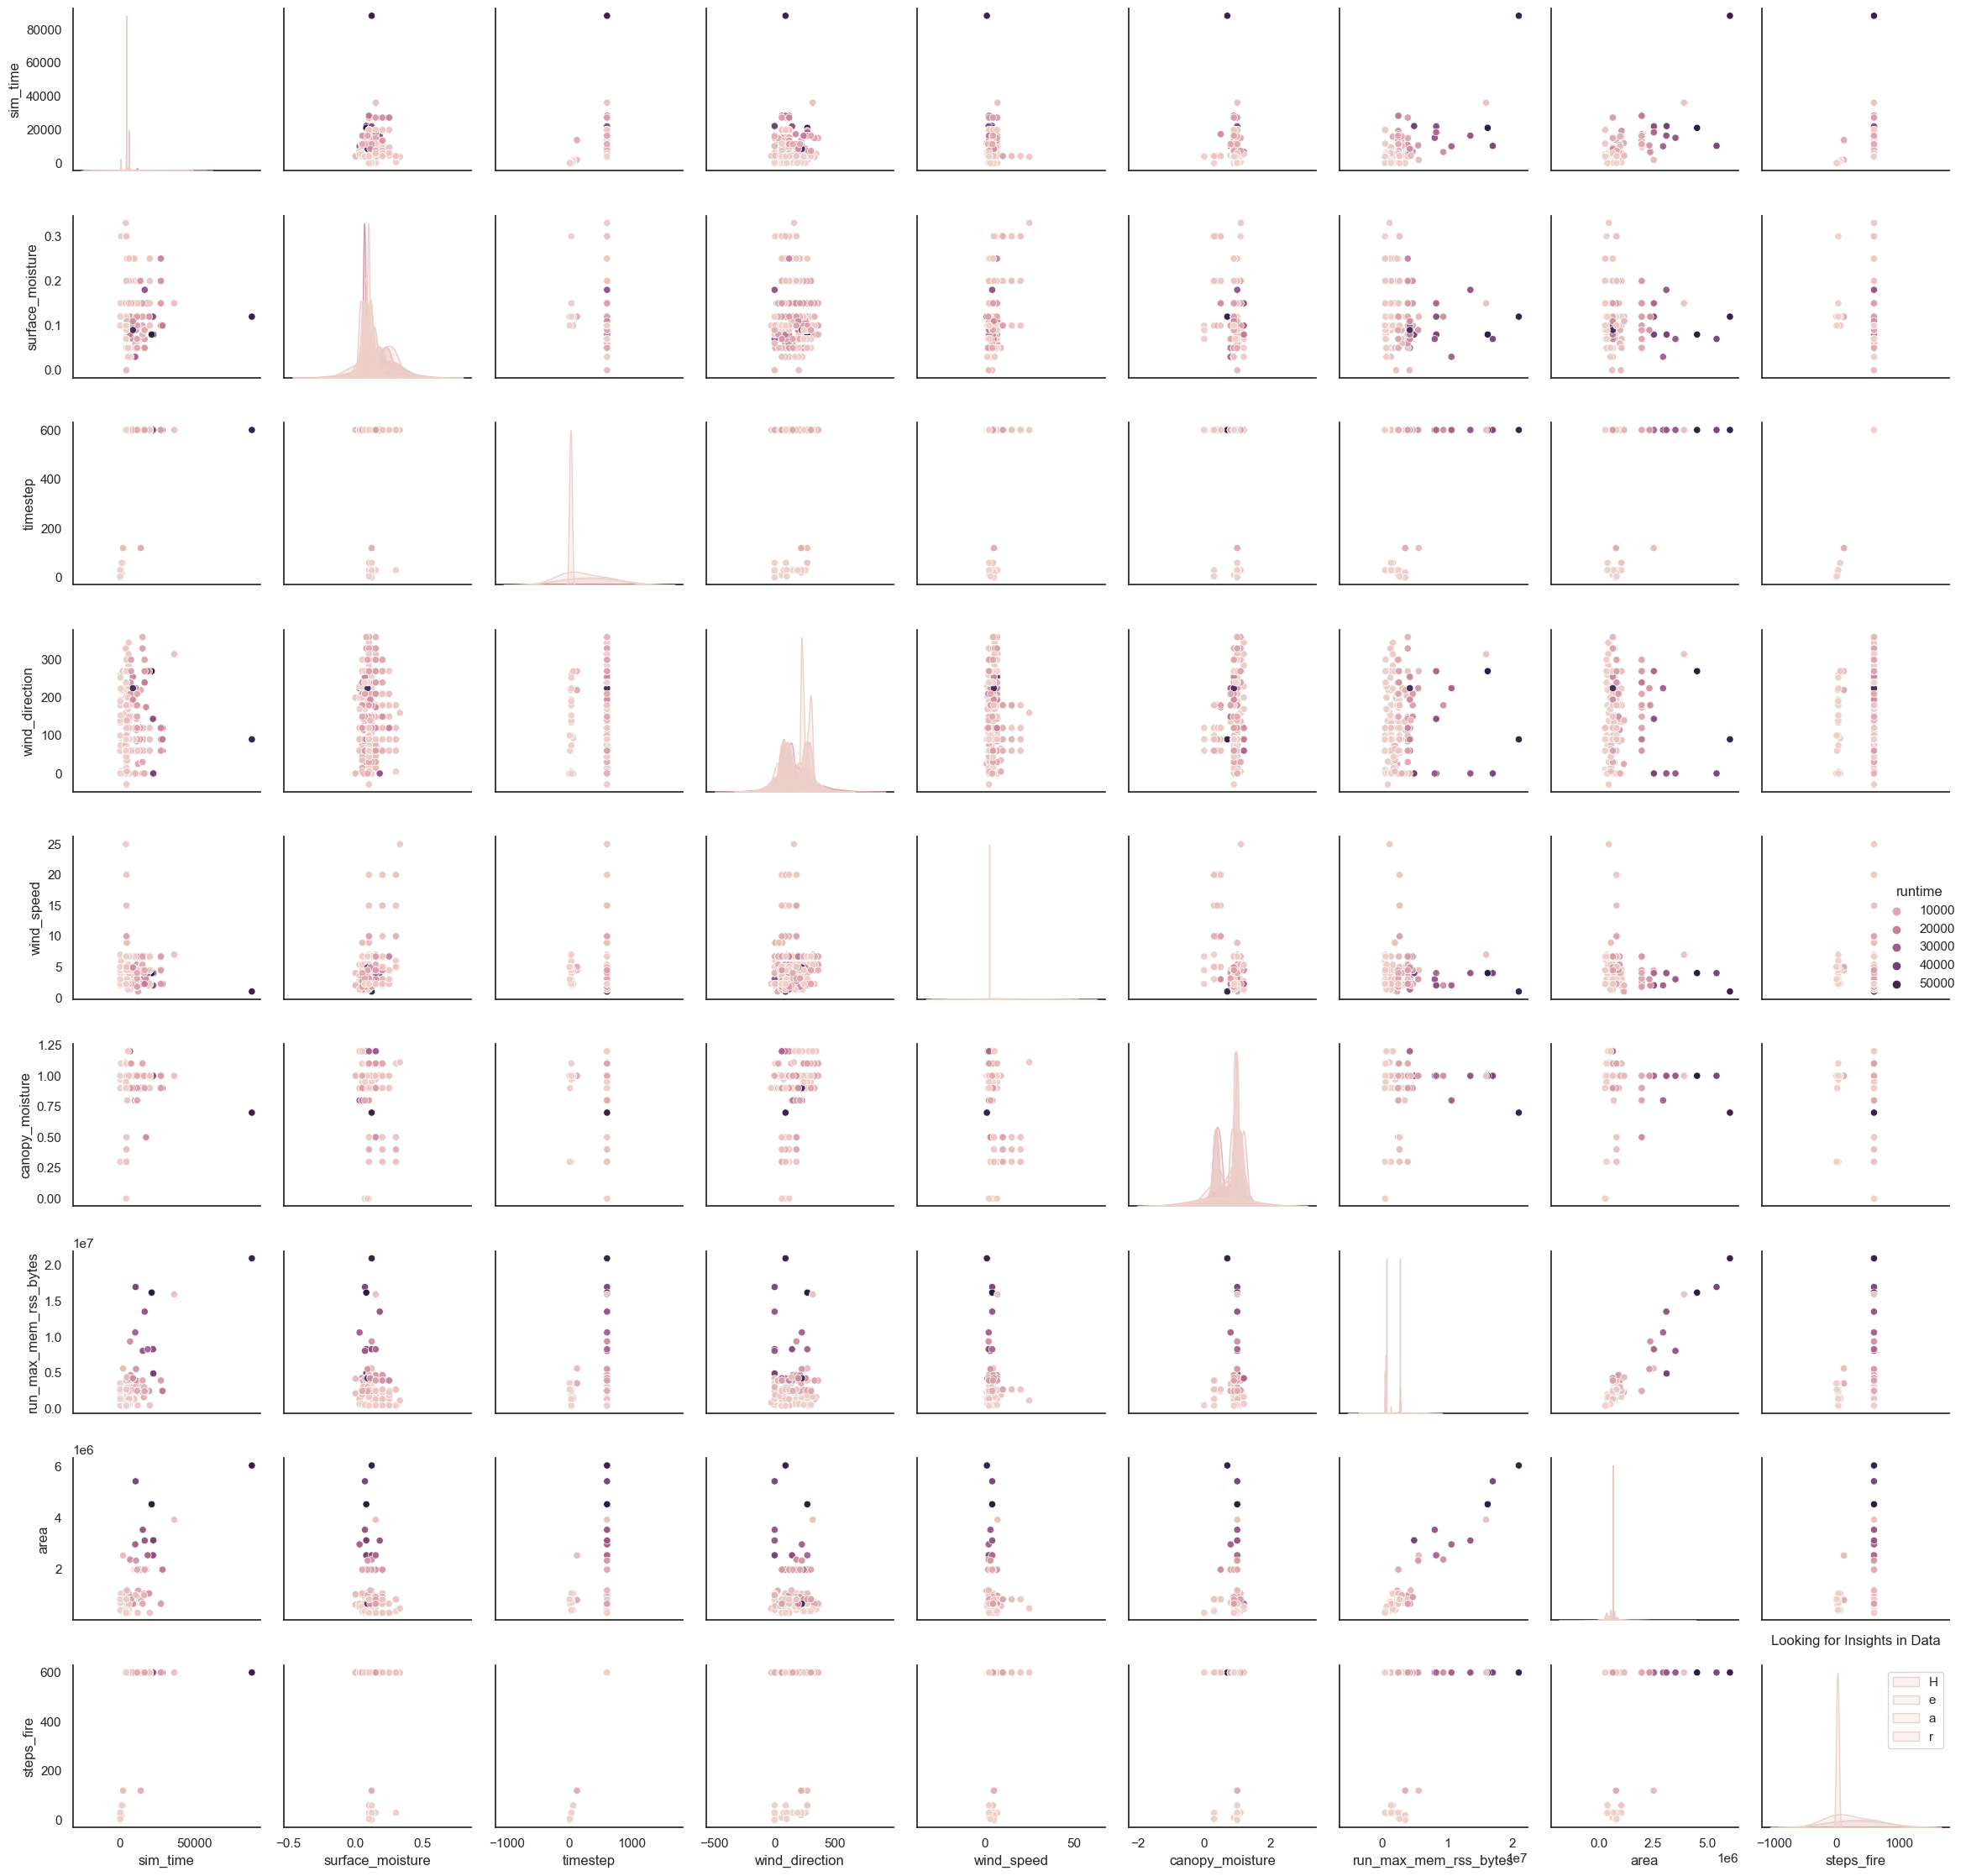

In [60]:
plt.figure(figsize=(15,10))
sns.pairplot(run_data,hue="runtime")
plt.title("Looking for Insights in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

/var/folders/cq/f_dhjpgn6f1gjlvmswx1nx4h0000gs/T/ipykernel_87906/220903559.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/cq/f_dhjpgn6f1gjlvmswx1nx4h0000gs/T/ipykernel_87906/220903559.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/cq/f_dhjpgn6f1gjlvmswx1nx4h0000gs/T/ipykernel_87906/220903559.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/cq/f_dhjpgn6f1gjlvmswx1nx4h0000gs/T/ipykernel_87906/220903559.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/cq/f_dhjpgn6f1gjlvmswx1nx4h0000gs/T/ipykernel_87906/220903559.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/cq/f_dhjpgn6f1gjlvmswx1nx4h0000gs/T/ipykernel_87906/220903559.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/cq/f_dhjpgn6f1gjlvmswx1nx4h0000gs/T/ipykernel_87906/220903559.p

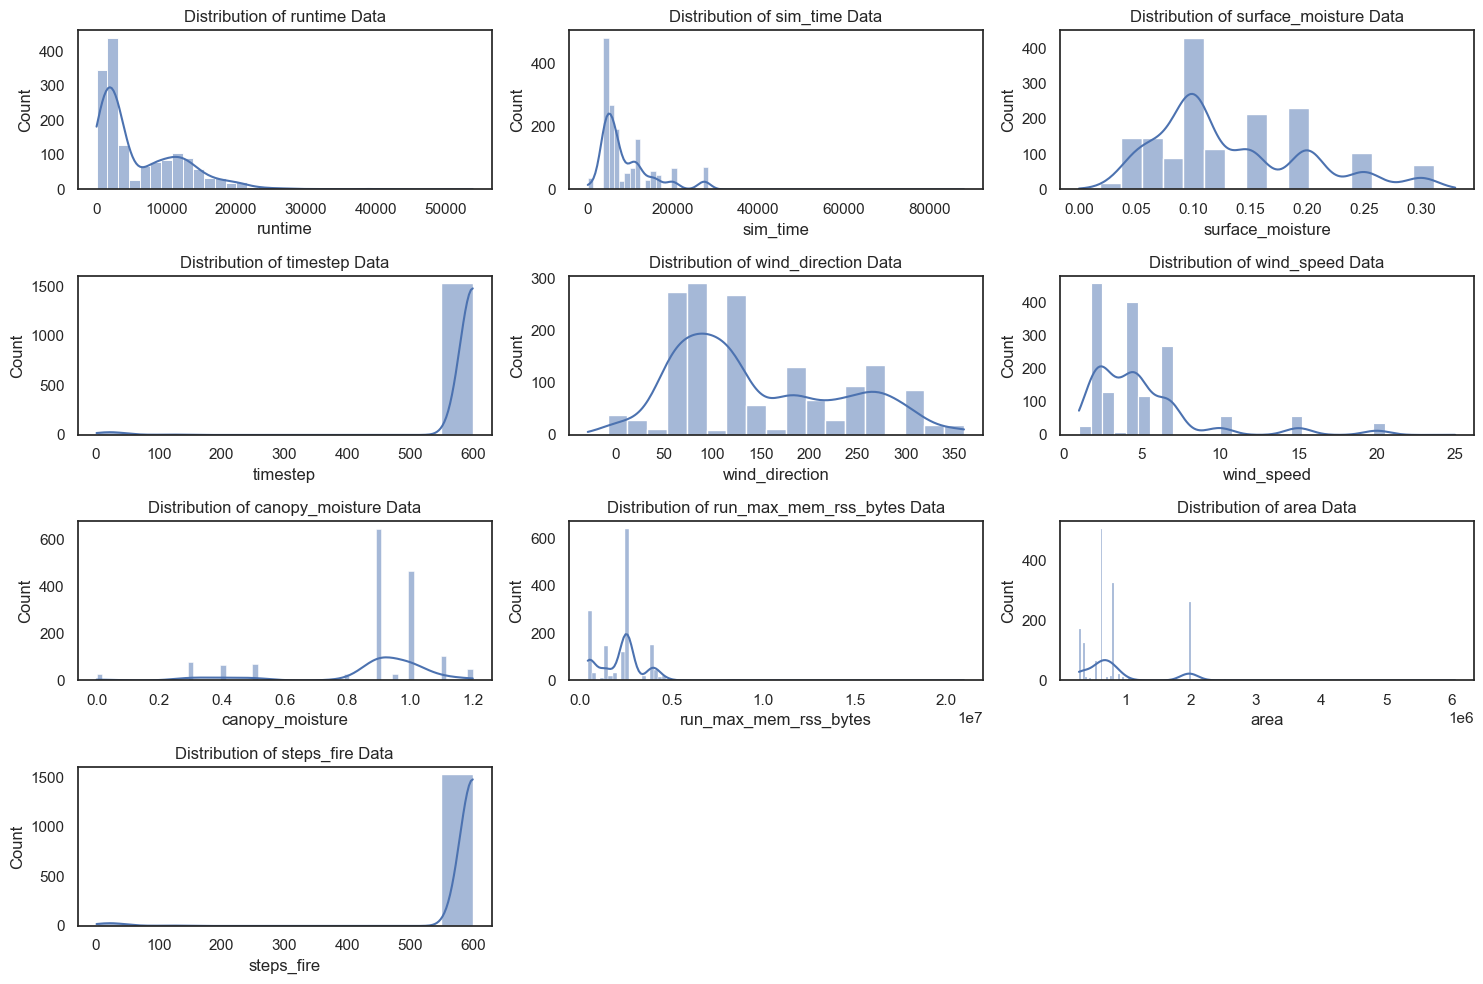

In [244]:
plt.figure(figsize=(15,10))
for i,col in enumerate(run_data.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(run_data[col],kde=True)
    plt.tight_layout()
    plt.plot()

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


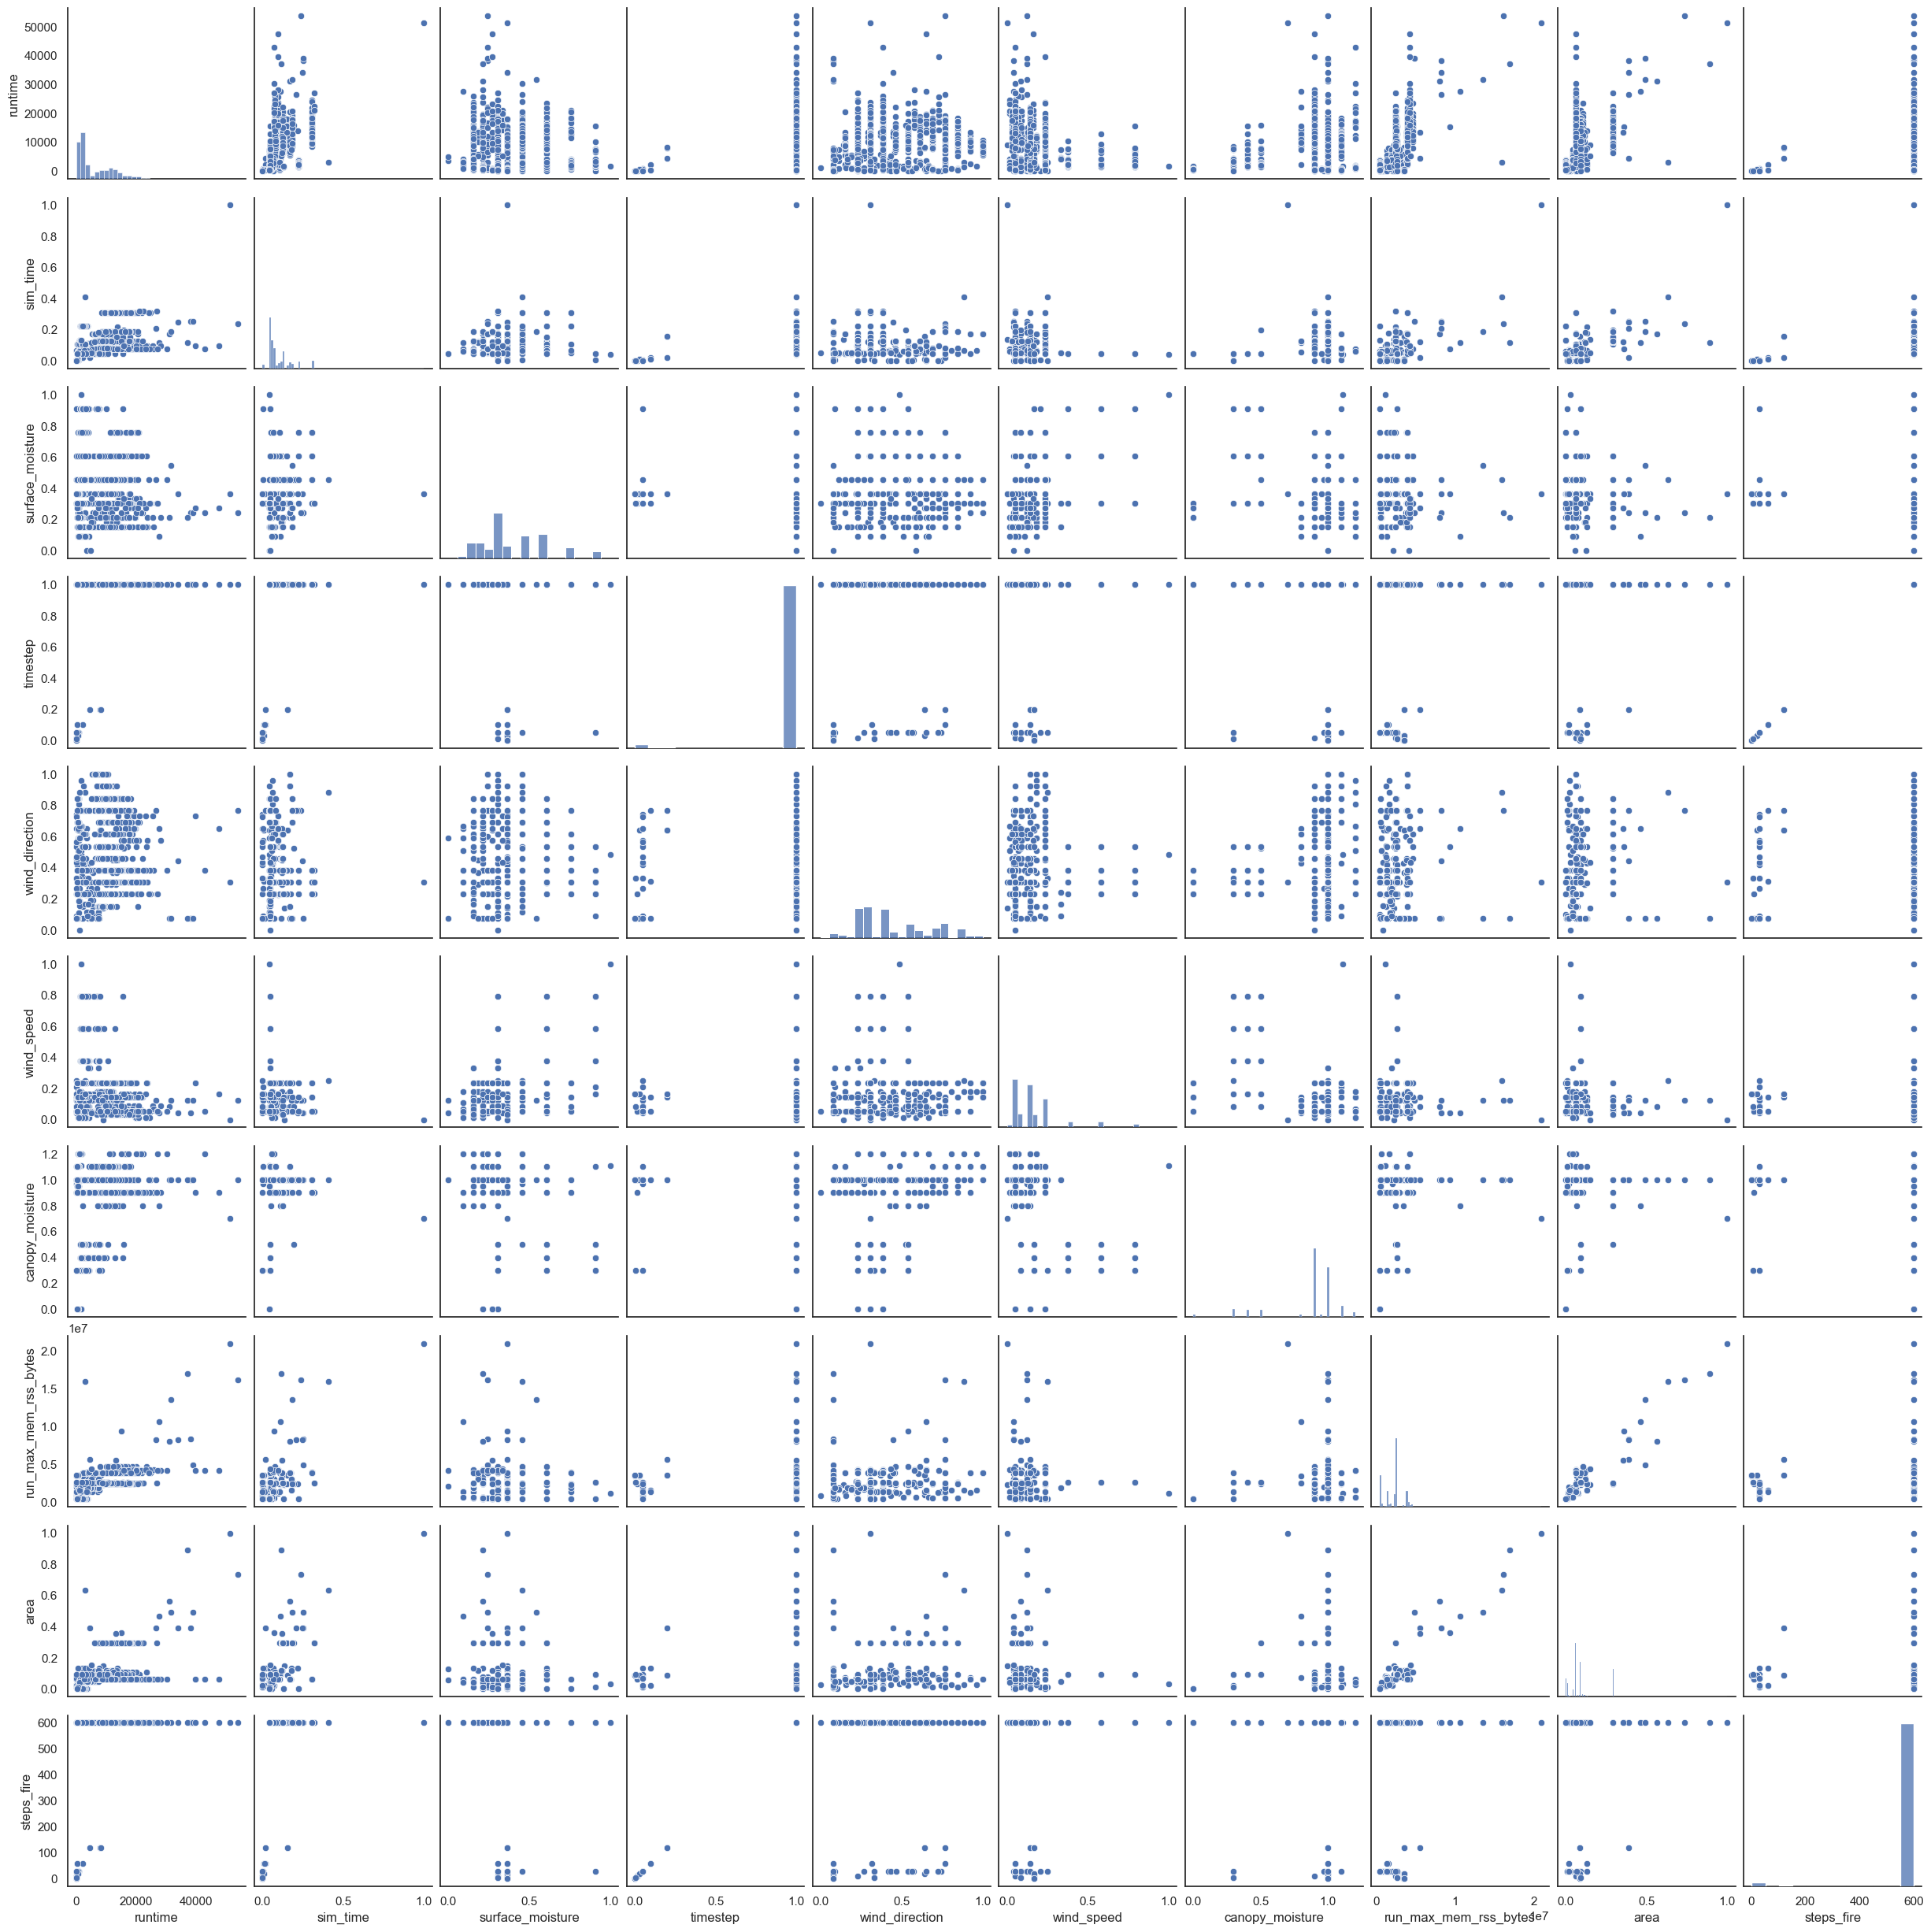

In [265]:
sns.pairplot(run_data)

In [61]:
print(len(run_data))
run_data.isnull().sum()

1567


runtime                  0
sim_time                 0
surface_moisture         0
timestep                 0
wind_direction           0
wind_speed               0
canopy_moisture          0
run_max_mem_rss_bytes    0
area                     0
steps_fire               0
dtype: int64

# Normalize

In [62]:
def normalize(series):
    return MinMaxScaler().fit_transform(np.array(series).reshape(-1,1))

In [63]:
y = pd.DataFrame(run_data['runtime'], columns=['runtime'])

for column in run_data.columns:
    run_data[column] = normalize(run_data[column])

X = run_data.drop(columns=["runtime"])
run_data.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
0,0.101433,0.050966,0.303030,1.0,0.241645,0.051458,0.833333,0.074582,0.046235,1.0
1,0.180538,0.128999,0.151515,1.0,0.305913,0.144583,0.750000,0.100625,0.293084,1.0
2,0.009113,0.044546,0.363636,1.0,0.768638,0.051458,0.791667,0.005656,0.011231,1.0
3,0.080088,0.055708,0.303030,1.0,0.426735,0.083333,0.916667,0.099840,0.131749,1.0
4,0.167007,0.170005,0.454545,1.0,1.000000,0.144583,0.833333,0.171107,0.061357,1.0


# K means clustering

In [64]:
# print(test_y.head())
# test_X.head()

In [65]:
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn.metrics as sm
from sklearn.model_selection import train_test_split

In [66]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train = np.array(X_train)


In [67]:
n_clusters = 10
model = KMeans(n_clusters=n_clusters)
model.fit(X)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10)

In [68]:
from random import randint

In [69]:
prediction = model.predict(X_test)
len(prediction)

392

In [70]:
y_test["runtime"] = (y_test["runtime"] / y_test["runtime"].max()) * n_clusters

d = pd.DataFrame({},columns=["answer","prediction"])
d["answer"] = y_test["runtime"]
d["prediction"] = prediction
d["difference"] = abs(d["answer"] - d["prediction"])
d

,answer,prediction,difference
558,0.409973,1,0.590027
674,2.995395,8,5.004605
742,0.598347,1,0.401653
415,0.154885,7,6.845115
185,3.704149,2,1.704149
...,...,...,...
368,3.387839,7,3.612161
562,2.436555,5,2.563445
1193,0.198838,2,1.801162
877,5.284653,7,1.715347


In [71]:
accuracy = 1 - (d["difference"].sum() / len(d) / n_clusters) 
print(f"{round(accuracy * 100,1)}% accurate")

74.2% accurate


In [72]:
len(run_data)

1567

# Linear Regression

In [73]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [74]:
model = LinearRegression().fit(np.array(X_train), np.array(y_train))

In [75]:
r_sq = model.score(np.array(X_test), np.array(y_test))
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"coefficients: {model.coef_}")

coefficient of determination: -25558765.711854357
intercept: [-5250.68683392]
coefficients: [[17665.63669291 -3516.49250548  2170.55792     1536.25571199
  -3690.78106748  2180.29559131 44770.38517899 14638.42526727
   2170.55792   ]]


In [76]:
y_pred = model.predict(X_test)
a = [a[0] for a in y_pred]
print(f"predicted response:\n{a[:4]}")

predicted response:
[1982.5782555059886, 11051.624612088743, 8556.446964331066, -657.5242264540193]


/usr/local/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [77]:
d = pd.DataFrame({},columns=["answer","prediction"])
d["answer"] = y_test
d["prediction"] = y_pred
d["difference"] = abs(d["answer"] - d["prediction"])
d

,answer,prediction,difference
558,0.409973,1982.578256,1982.168282
674,2.995395,11051.624612,11048.629217
742,0.598347,8556.446964,8555.848618
415,0.154885,-657.524226,657.679111
185,3.704149,10747.382623,10743.678473
...,...,...,...
368,3.387839,11737.557044,11734.169205
562,2.436555,11547.933590,11545.497036
1193,0.198838,1846.616911,1846.418073
877,5.284653,12654.586340,12649.301687


In [78]:
accuracy = 1 - (d["difference"].sum() / len(d) / n_clusters) 
print(f"{round(accuracy * 100,1)}% accurate")

-65160.8% accurate


In [80]:
# run_data['fire_step'] = simulation_runs['output']['fire_step']

run_data.to_csv('training_data.csv')

# Testing Dataframe merges

In [81]:
import pandas as pd
from datetime import datetime,timedelta

In [82]:
d1 = {
    "time":[1.3e6,3.2e8,4],
    # "time":[datetime.now(),datetime.now()-timedelta(seconds=30),datetime.now()-timedelta(seconds=50)],
    "cpu":[1,0.3,0.6],
}
d2 = {
    "time":[1.3e6,3.2e8,7],
    # "time":[datetime.now(),datetime.now()-timedelta(seconds=10),datetime.now()-timedelta(seconds=500)],
    "mem":[.3,0.8,0.9],
}
df1 = pd.DataFrame(data=d1)
df1 = df1.set_index("time")
df2 = pd.DataFrame(data=d2)
df2 = df2.set_index("time")

display(df1)
display(df2)

,cpu
time,
1300000.0,1.0
320000000.0,0.3
4.0,0.6


,mem
time,
1300000.0,0.3
320000000.0,0.8
7.0,0.9


In [83]:
pd.concat([df1, df2], axis=1)

,cpu,mem
time,,
1300000.0,1.0,0.3
320000000.0,0.3,0.8
4.0,0.6,NaN
7.0,NaN,0.9


<Axes: xlabel='runtime'>

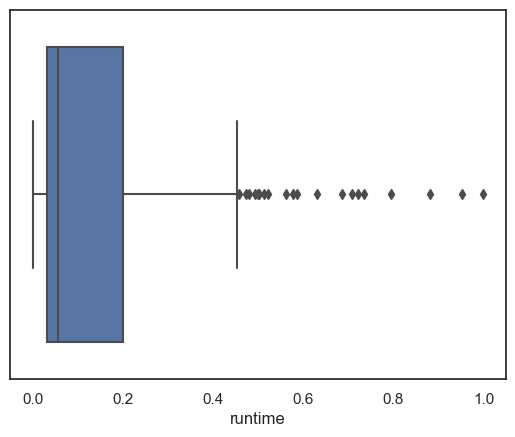

In [89]:
sns.boxplot(x=run_data['runtime'])